In [1]:
# Импорт необходимых библиотек, и модулей
import os
import pandas as pd
import numpy as np
import cv2
from statistics import mean
from Builder_tools.Unit_tools import MediaPiPe_detector
from Builder_tools.Augmentation_tools_keras import SMOTE, Generate_img_model
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('dark_background')
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", physical_devices)
print('TF_VERSION: ',tf.__version__)

2024-02-12 17:55:50.891692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 17:55:50.891730: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 17:55:50.892679: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 17:55:50.963622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 17:55:53.506367: I tensorflow/compiler/

Num GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF_VERSION:  2.14.1


In [2]:
# Настройка лимитов на память GPU (Обучаю на своей машине)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2024-02-10 11:54:10.361898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 11:54:10.362046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 11:54:10.362139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Проверяем данные на наличие несбалансированности 

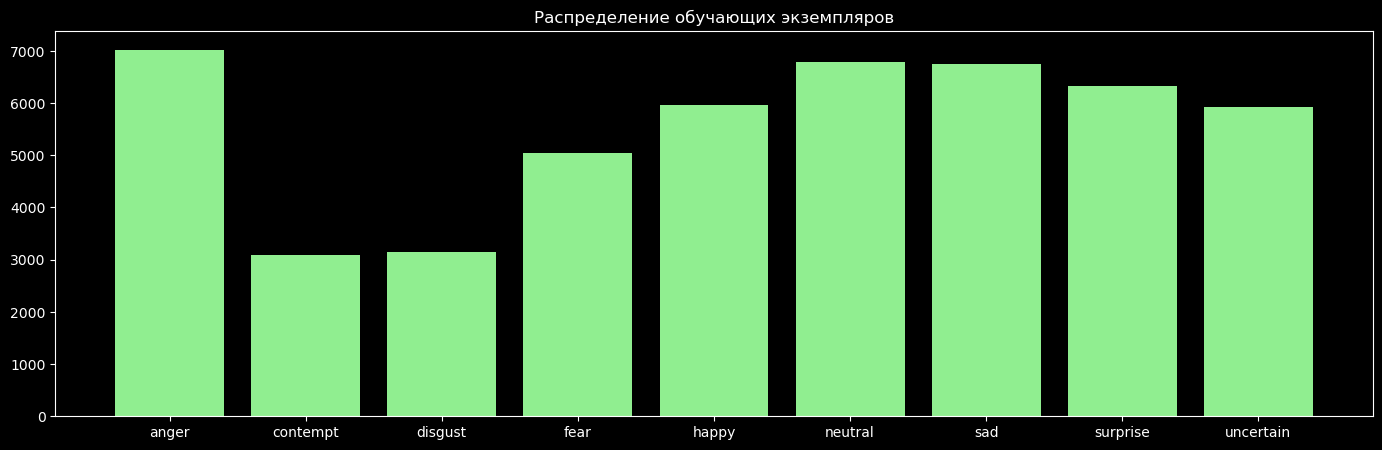

In [2]:
# Создаю словарь категорий и колличества экземпляров для обучения
curr_folder = 'train/'
count_d = {}
for name_folder in os.listdir(curr_folder):
    count_d[name_folder] = len(os.listdir(curr_folder + name_folder))
    
# Посмотрим на соотношение категорий в тренировочном наборе данных
# Строю границы графика
fig, ax = plt.subplots(figsize=(17,5))
# Строю сам график
ax.bar(count_d.keys(),count_d.values(), color='lightgreen')
ax.set_title('Распределение обучающих экземпляров')
plt.show();

##  Генерация новых данных в соответствии с нашей будущей архитектурой

In [ ]:
# # Посмотрим среднее значение количества экземпляров в каждом классе
# mean_class_obj = int(mean([i for k, i in count_d.items()]))
# print(mean_class_obj)

In [2]:
# Определяем детектор лиц в нашем случае это будет MediaPipe
face_detector = MediaPiPe_detector()
# И модель для аугментации изображений
augmentation_model = Generate_img_model()

# Определим экземпляр класса SMOTE который будет отвечать за понижающий/повышающий отбор;
# Установим колличество необходимых экземпляров в каждом классе по значению среднего значения mean_class_obj;
# IMAGE_SIZE  выходных изображений установим в 224, так как будем применять модель  RESNet50
smote_aug = SMOTE(path_folder_train_data='train/', 
                 path_save_imgs='new_train/',
                  face_detector=face_detector,
                  gen_model = augmentation_model, IMAGE_SIZE=224,
                  smote_value=7000,
                  train_part=0.15, modify_coef=0.3)

In [ ]:
# Сгенерируем новые данные, для дальнейшего обучения
smote_aug.smote()

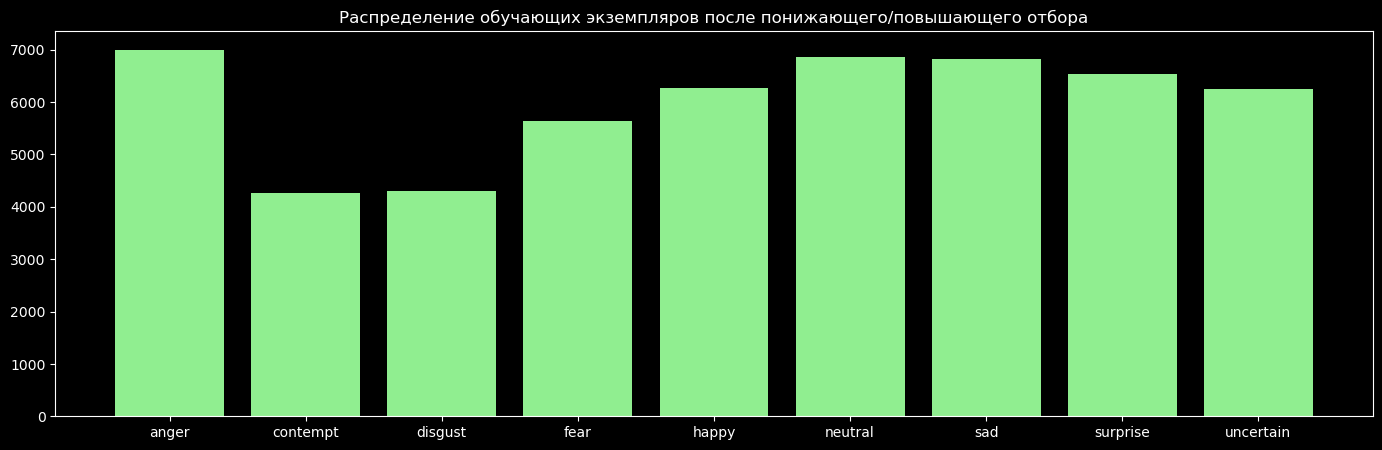

In [4]:
# Создаю словарь категорий и колличества экземпляров для обучения
curr_folder = 'new_train/'
count_d = {}
for name_folder in os.listdir(curr_folder):
    count_d[name_folder] = len(os.listdir(curr_folder + name_folder))
    
# Посмотрим на соотношение категорий в тренировочном наборе данных
# Строю границы графика
fig, ax = plt.subplots(figsize=(17,5))
# Строю сам график
ax.bar(count_d.keys(),count_d.values(), color='lightgreen')
ax.set_title('Распределение обучающих экземпляров после понижающего/повышающего отбора')
plt.show();

In [5]:
# Сохраняю перечень плохих экземпляров
df_bad = pd.DataFrame(smote_aug.bad_img_list, columns=['folder', 'id_jpg'])
df_bad.to_csv('bad_jpg.csv')

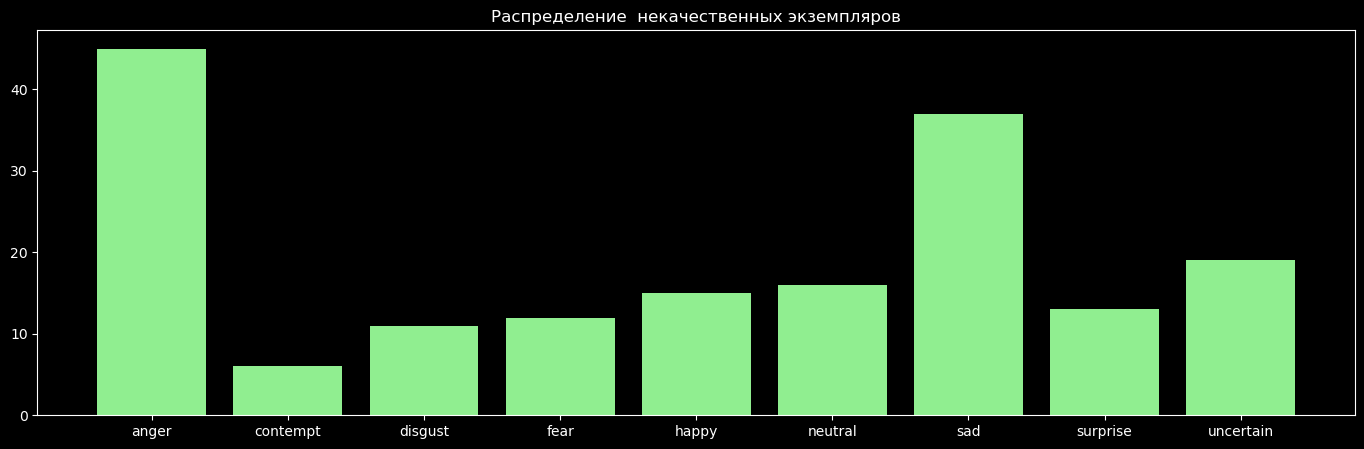

In [6]:
# Посмотрим как распределены плохие экземпляры
count_d = df_bad.groupby('folder').count().to_dict()['id_jpg']
fig, ax = plt.subplots(figsize=(17,5))
ax.bar(count_d.keys(),count_d.values(), color='lightgreen')
ax.set_title('Распределение  некачественных экземпляров')
plt.show();

In [7]:
# Общее количество экземпляров с плохим качеством
print(f'Общее количество экземпляров с плохим качеством: {df_bad.shape[0]}')

Общее количество экземпляров с плохим качеством: 174


In [8]:
# Функция рисовальщик
def show_face(df, num_sumples=20):
    # Перемешиваем датафрейм
    df = df.sample(frac=1).reset_index(drop=True)
    df = df.head(num_sumples)
    plt.figure(figsize=(15, 15))
    grid_size = np.ceil(np.sqrt(df.shape[0])).astype(np.int)
    
    for e_num, (i_folder, i_id_img) in enumerate(zip(df['folder'], df['id_jpg'])):
        img = cv2.imread(f'train/{i_folder}/{i_id_img}')[...,::-1] # Конвертирую в RGB
        plt.subplot(grid_size, grid_size, e_num+1)
        plt.imshow(img)
        plt.title(i_folder)
        plt.xticks([]); plt.yticks([])
    plt.show();

/tmp/ipykernel_13628/4070407031.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_size = np.ceil(np.sqrt(df.shape[0])).astype(np.int)


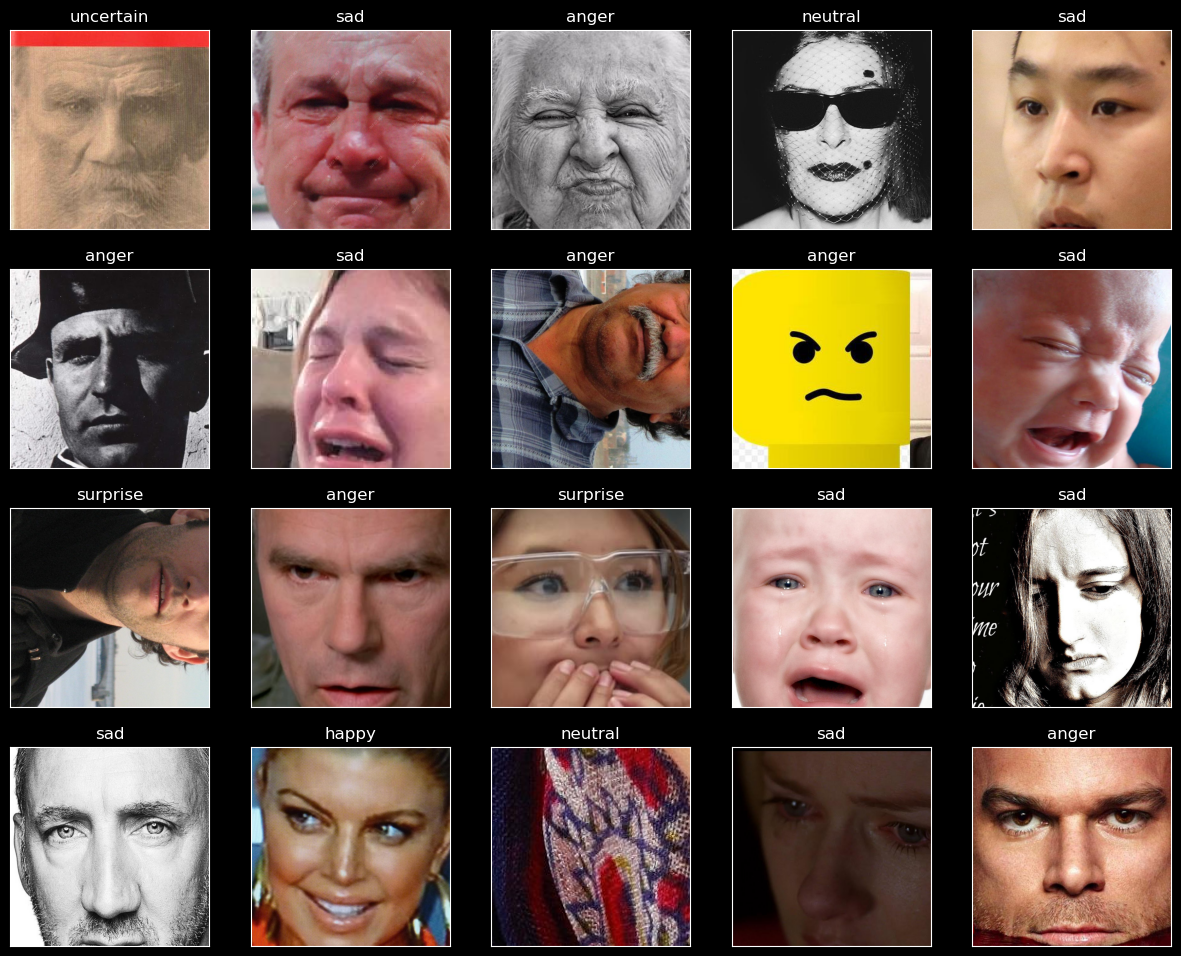

In [23]:
# Нарисуем экземпляры, на которых не сработал детектор
show_face(df_bad)

In [9]:
# Экземпляры с детекцией более одного лица на изображении
df_mul_face = pd.DataFrame(smote_aug.multi_faces_list, columns=['folder', 'id_jpg'])
df_mul_face.to_csv('mul_face.csv')

In [10]:
# Общее количество множественных детекций
print(f'Общее количество множественных детекций: {df_mul_face.shape[0]}')

Общее количество множественных детекций: 360


/tmp/ipykernel_13628/4070407031.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid_size = np.ceil(np.sqrt(df.shape[0])).astype(np.int)


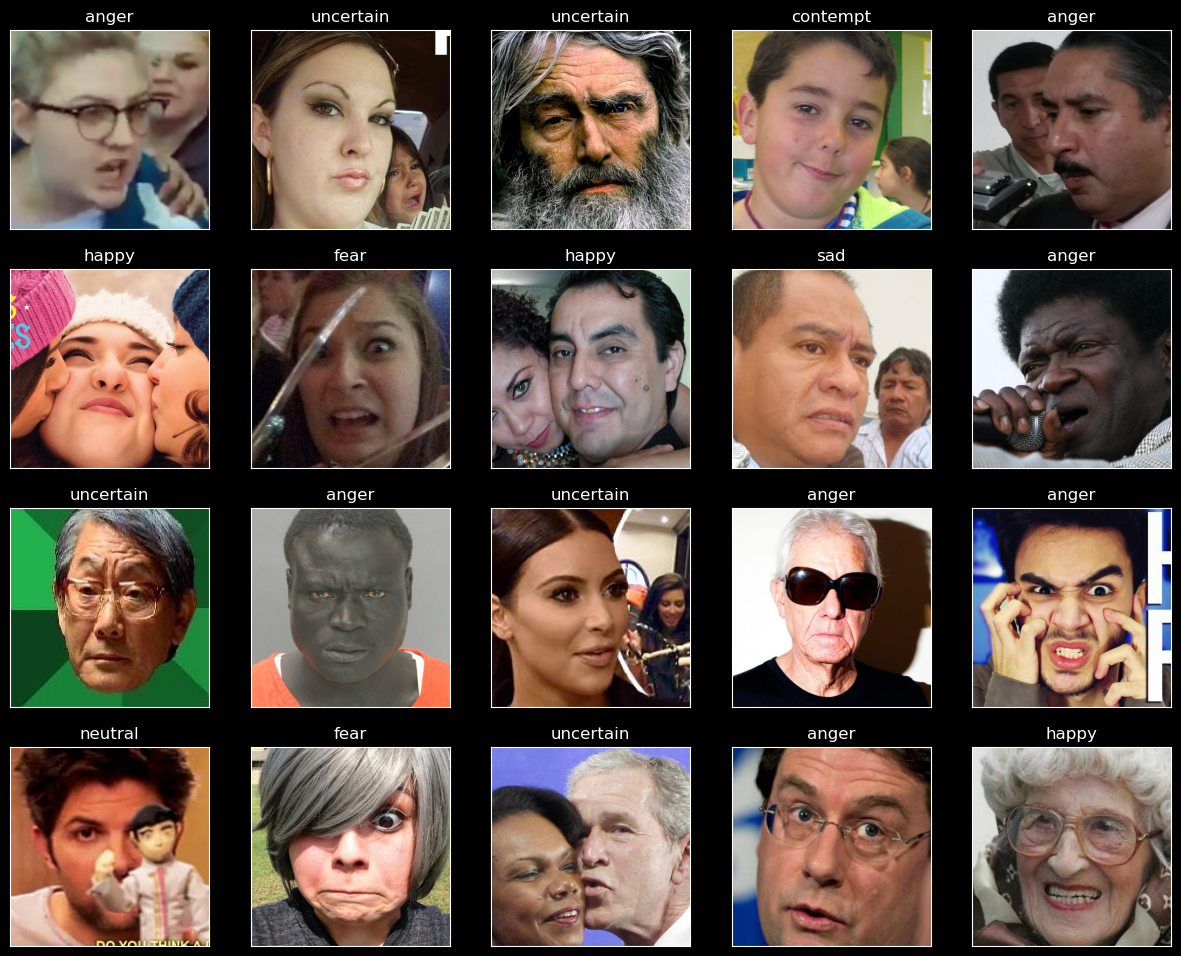

In [27]:
# Нарисуем экземпляры с мультидетекцией
show_face(df_mul_face)

## Создаем файл CSV в котором будут отражены пути к новым обучающим данным

In [11]:
# Создаю словарь категорий и колличества экземпляров для обучения
curr_folder = 'new_train/'
path = []
category =[]
id_img = []
train_test_label = []
for name_folder in os.listdir(curr_folder):
    for i_img in os.listdir(curr_folder + name_folder):
        path.append(f'{curr_folder}{name_folder}/{i_img}')
        category.append(name_folder)
        id_img.append(i_img)
        if int(i_img.split('.jpg')[0]) < smote_aug.hight_train_index[name_folder]: # Верхний индекс экземпляров по каждой категории после которого отложены тестовые данные
            train_test_label.append('train')
        else:
            train_test_label.append('test')

# Создаем датафрейм
out_df = pd.DataFrame({'path': path, 'category': category, 'id_img': id_img, 'train_test':train_test_label})
out_df.head()

,path,category,id_img,train_test
0,new_train/anger/1.jpg,anger,1.jpg,train
1,new_train/anger/10.jpg,anger,10.jpg,train
2,new_train/anger/100.jpg,anger,100.jpg,train
3,new_train/anger/1000.jpg,anger,1000.jpg,train
4,new_train/anger/1001.jpg,anger,1001.jpg,train


In [12]:
# Количество тренировочных экземпляров
train_ex = out_df[out_df.train_test =='train'].category.value_counts()
train_ex

category
anger        5949
neutral      5826
sad          5794
surprise     5546
happy        5326
uncertain    5309
fear         4784
disgust      3660
contempt     3619
Name: count, dtype: int64

In [13]:
test_ex = out_df[out_df.train_test =='test'].category.value_counts()
test_ex

category
anger        1051
neutral      1030
sad          1024
surprise      980
happy         942
uncertain     939
fear          846
disgust       648
contempt      640
Name: count, dtype: int64

In [14]:
# Соотношение тестовых данных по отношению к тренировочным
test_ex / train_ex

category
anger        0.176668
neutral      0.176794
sad          0.176735
surprise     0.176704
happy        0.176868
uncertain    0.176869
fear         0.176839
disgust      0.177049
contempt     0.176844
Name: count, dtype: float64

In [15]:
# Проверим соотношение тренировочных данных и тестовых
n_train = out_df[out_df['train_test'] == 'train'].shape[0]
n_test = out_df[out_df['train_test'] == 'test'].shape[0]
perc_n_train = n_train / (n_train + n_test)
perc_n_test = n_test / (n_train + n_test)
print(f'Общее количество экземпляров: {n_train + n_test}')
print(f'Количество тренировочных данных: {n_train}')
print(f'Количество тестовых данных: {n_test}')
print(f'Процентное соотношение тренировочных и тестовых данных: Тренировочные {round(perc_n_train,2)}, Тестовые {round(perc_n_test, 2)}')

Общее количество экземпляров: 53913
Количество тренировочных данных: 45813
Количество тестовых данных: 8100
Процентное соотношение тренировочных и тестовых данных: Тренировочные 0.85, Тестовые 0.15


In [16]:
# Сохраним результаты 
out_df.to_csv('new_train.csv')